In [1]:
from mpl_toolkits.mplot3d import Axes3D         # Cargo Axes3D de mpl_toolkits.mplot3d
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import pandas as pd
from matplotlib import animation
import sys 
import math
%matplotlib inline

In [2]:
#Libreria para programar en parallelo
from pyspark import SparkContext
import multiprocessing as mp

In [3]:
#Trabajamos con 2 nucleos
nuc = 2
#sc=SparkContext(master="local[2]")
sc = SparkContext(master='local[2]')

In [4]:
sc

<SparkContext master=local[2] appName=pyspark-shell>

In [5]:
data = np.loadtxt('/home/echeveste/mis_trabajos/correlation_f/data/data_500.dat')[:,:3]
rand = np.loadtxt('/home/echeveste/mis_trabajos/correlation_f/data/rand0_500.dat')[:,:3]

data_rand = sc.parallelize(np.split(np.concatenate((data, rand)),2))

In [6]:
def dis_XX(p,bn,point_max):
    """ 
    Función para construir los histogramas 
    
    p = datos
    bn = tamaño de bins
    point_max = punto máximo en el histograma
    
    """
    
    #Inicializamos los arreglos de los histogramas
    NDDD = np.zeros((bn,bn,bn))
    
    # =========================================================================================== 
    
    n = 0
    for (ii) in zip(p):
        n = n+1
        
        s = ii-p[n:] # Diferencia entre el punto pivote y los demas puntos siguientes 
        r = np.sqrt(s[:,0]**2+s[:,1]**2+s[:,2]**2)
        
        m = 0
        for (kk) in zip(p[n:]):
            
            #DDD ===============================================================================
            r12 = np.ones_like(r[m+1:])*r[m]
            r13 = r[m+1:]
        
            ss = kk-p[n:][m+1:] # Diferencia entre el punto pivote y los demas puntos siguientes 
            r32 = np.sqrt(ss[:,0]**2+ss[:,1]**2+ss[:,2]**2)
        
            # Histogramas para DDD
            dis, dim = np.histogramdd(np.array([r12,r13,r32]).T,bins = [bn,bn,bn], 
                                    range=[[0,point_max],[0,point_max],[0,point_max]])
            NDDD = NDDD + dis
            
            m = m+1
    
    return NDDD

In [7]:
def dis_XY(p,p_r,bn,point_max):
    
    NDDR = np.zeros((bn,bn,bn))
    NDRR = np.zeros((bn,bn,bn))
    
    n = 0
    for (ii, jj) in zip(p, p_r):
        n = n+1
        
        s = ii-p[n:] # Diferencia entre el punto pivote y los demas puntos siguientes 
        r = np.sqrt(s[:,0]**2+s[:,1]**2+s[:,2]**2)
        
        s_ran = jj-p_r[n:] # Diferencia entre el punto pivote y los demas puntos siguientes 
        r_ran = np.sqrt(s_ran[:,0]**2+s_ran[:,1]**2+s_ran[:,2]**2)
        
        m = 0
        for (kk, ll) in zip(p[n:], p_r[n:]):
            #DDR ===============================================================================
            r12 = np.ones_like(p_r.T[0])*r[m]
            
            ss = ii-p_r # Diferencia entre el punto pivote y el punto en la muestra random 
            r13 = np.sqrt(ss[:,0]**2+ss[:,1]**2+ss[:,2]**2)
            
            ss = kk-p_r # Diferencia entre el punto 2 de los datos y el punto en la muestra random 
            r32 = np.sqrt(ss[:,0]**2+ss[:,1]**2+ss[:,2]**2)
            
            # Histogramas para DDR
            dis, dim = np.histogramdd(np.array([r12,r13,r32]).T,bins = [bn,bn,bn], 
                                    range=[[0,point_max],[0,point_max],[0,point_max]])
            NDDR = NDDR + dis
            
            #DRR ===============================================================================
            r12 = np.ones_like(p.T[0])*r_ran[m]
            
            ss = jj-p # Diferencia entre el punto pivote random y el punto en los datos 
            r13 = np.sqrt(ss[:,0]**2+ss[:,1]**2+ss[:,2]**2)
            
            ss = ll-p # Diferencia entre el punto 2 de la muestra random y el punto en los datos 
            r32 = np.sqrt(ss[:,0]**2+ss[:,1]**2+ss[:,2]**2)
            
            # Histogramas para DRR
            dis, dim = np.histogramdd(np.array([r12,r13,r32]).T,bins = [bn,bn,bn], 
                                    range=[[0,point_max],[0,point_max],[0,point_max]])
            NDRR = NDRR + dis
            
            m = m+1

    return NDDR,NDRR

In [32]:
#FUNCIÓN DE PARA HACER HISTOGRAMAS 
def Histos(data,bn,point_max,nuc):
    """ 
    Función para construir los histogramas 
    
    p = datos
    bn = tamaño de bins
    point_max = punto máximo en el histograma
    
    """

    XXX =  np.zeros((bn,bn,bn))
    tam = len(data)
    
    #Hacemos una subdivición de los samples en el número de núcleos
    p = sc.parallelize(np.split(data,[x for x in range(math.ceil(tam/nuc),tam,math.ceil(tam/nuc))])) 
    
    #Sacamos los histogramas de los triangulos de casa subconjunto 
    XXX_1 = p.map(lambda x: dis_XX(x,bn,point_max)).collect()
    
    for ii in XXX_1:
        XXX = XXX+ii
        
    #Sacamos los histogramas de los triangulos entre los subconjuntos
    #print(XXX_1)
    #print('===================================')
    n = 0
    for ii in p.collect()[:nuc-1]:
        n = n+1
        
        pool = mp.Pool(processes=len(p.collect()[n:]))      
        results = [pool.apply_async(dis_XY, args=(ii,jj,bn,point_max)) for jj in p.collect()[n:]]   
        output = [b.get() for b in results]
        print(len(output))
        print('===================================')
        for i in range(len(output)):
            XXX = XXX + output[i][0] + output[i][1]

    return XXX

In [33]:
#Paralelizado
start = time.perf_counter()

nuc = 4

sc.stop()
sc = SparkContext(master='local[{0}]'.format(int(nuc)))
print(sc.master)

DDD = Histos(data,30,180,nuc)
finish = time.perf_counter()

print(f'Finializó en {round(finish-start,2)} segundos\n')

local[4]
3
2
1
Finializó en 23.1 segundos



In [34]:
DDD[0].get()

AttributeError: 'numpy.ndarray' object has no attribute 'get'

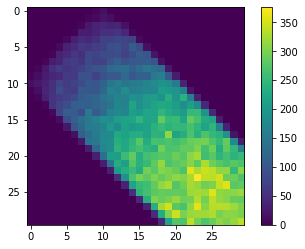

In [35]:
plt.imshow(DDD[10])
cax=plt.colorbar()

In [28]:
p.glom().collect()[:2][0][0]

array([[1.03752487e+02, 2.43126556e+02, 1.87786346e+02],
       [7.33624040e+01, 4.91394500e+01, 1.11009155e+02],
       [2.29819611e+02, 1.56321869e+02, 1.24974083e+02],
       [1.62194611e+02, 2.39083023e+02, 9.23825450e+01],
       [1.70629440e+02, 1.31974167e+02, 2.39027939e+02],
       [1.04319336e+02, 2.37442108e+02, 1.94095596e+02],
       [8.84048080e+01, 1.51310303e+02, 2.06816299e+02],
       [2.05245010e+02, 6.90782850e+01, 8.81324310e+01],
       [5.12894970e+01, 7.40727460e+01, 4.37923970e+01],
       [1.25981033e+02, 1.39976501e+02, 4.79803700e+01],
       [1.73809982e+02, 4.56609190e+01, 1.05352501e+02],
       [2.30068344e+02, 2.31861603e+02, 1.22900887e+02],
       [8.72935410e+01, 1.43003403e+02, 7.63205950e+01],
       [1.45222290e+01, 2.32926605e+02, 1.68616211e+02],
       [6.65628590e+01, 1.39607407e+02, 1.25251724e+02],
       [1.68134650e+01, 5.12482830e+01, 1.13697899e+02],
       [1.40126587e+02, 5.48707600e+00, 4.89443900e+00],
       [1.70635190e+01, 1.63401

In [16]:
n = len(data)
nuc = 4
sc.stop()
#sc=SparkContext(master="local[2]")
sc = SparkContext(master='local[{0}]'.format(int(nuc)))
p = sc.parallelize(np.split(data,[x for x in range(math.ceil(n/nuc),n,math.ceil(n/nuc))]))

In [367]:
ss  = p.map(lambda x: dis_XX(x,30,180)).collect()

In [382]:
otro_ss = dis_XY(p.collect()[0],p.collect()[1],30,180)

249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
217
216
215
214


KeyboardInterrupt: 

Process ForkPoolWorker-1544:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 356, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [376]:
p.collect()[1]

array([[2.77733500e+00, 5.16159060e+01, 1.00577050e+01],
       [7.56418910e+01, 1.04625270e+01, 1.23801971e+02],
       [3.62321130e+01, 2.08007600e+00, 2.43175278e+02],
       [1.09561111e+02, 1.21666382e+02, 1.49087143e+02],
       [4.43062550e+01, 2.00457413e+02, 2.00584488e+02],
       [1.80282520e+01, 9.43296510e+01, 5.27272640e+01],
       [1.51665010e+01, 3.28548970e+01, 4.27002030e+01],
       [1.85398651e+02, 9.59218370e+01, 2.25817123e+02],
       [2.46290090e+01, 6.66526870e+01, 1.91996506e+02],
       [2.07211731e+02, 1.89553879e+02, 4.17249450e+01],
       [2.14826599e+02, 8.84695510e+01, 2.03573471e+02],
       [1.69158860e+01, 4.39612460e+01, 1.34622055e+02],
       [9.41604920e+01, 2.38309647e+02, 2.36148727e+02],
       [1.48277954e+02, 2.29391586e+02, 1.63221222e+02],
       [2.21623825e+02, 2.38962219e+02, 1.54521744e+02],
       [4.02506940e+01, 2.57045140e+01, 1.69697266e+02],
       [7.94111560e+01, 1.55832062e+02, 9.06613310e+01],
       [2.07802902e+02, 3.54503

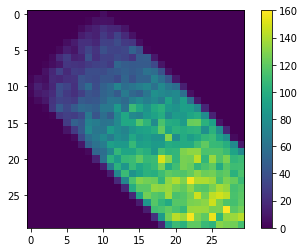

In [373]:
ss[0]+ss[1]+otro_ss
plt.imshow((ss[0]+ss[1]+otro_ss)[10])
cax=plt.colorbar()

In [277]:
len(p.collect())

2

In [278]:
bn = 30
XXX = np.zeros((bn,bn,bn))

start = time.perf_counter()

pool = mp.Pool(processes=len(p.collect()))      
results = [pool.apply_async(dis_XX, args=(jj,30,180,)) for jj in p.collect()]   
output = [b.get() for b in results]
print(len(output))
  
for i in range(len(output)):
    #print(i)
    XXX = XXX + output[i][0]
    
    
finish = time.perf_counter()
    
print(f'Finializó en {round(finish-start,2)} segundos\n')

2
Finializó en 10.34 segundos



Process ForkPoolWorker-1497:
Process ForkPoolWorker-1498:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 356, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/

In [442]:
[p.collect()[2:]]

[[]]

In [314]:
bn = 30
NDDR = np.zeros((bn,bn,bn))
NDRR = np.zeros((bn,bn,bn))
    
n = 0
for ii in p.collect()[:nuc-1]:
    n = n+1
        
    pool = mp.Pool(processes=len(p.collect()[n:]))      
    results = [pool.apply_async(dis_XY, args=(ii,jj,30,180,)) for jj in p.collect()[n:]]   
    output = [b.get() for b in results]
    print(len(output))
    
    for i in range(len(output)):
        #print(i)
        NDDR = NDDR + output[i][0]
        NDRR = NDRR + output[i][1]
    

2
2
2


Process ForkPoolWorker-1542:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 356, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [259]:
len(output[0][1])

30

In [196]:
NDDR

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 1.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  5.,  2.,  0.],
        [ 0.,  0.,  0., ...,  6.,  3.,  0.],
        [ 0.,  0.,  0., ...,  0.,  3.,  4.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[ 0.,  0.,  0., ..., 12.,  0.,  0.],
        [ 0.,  0.,  0., ...,  3.,  3.,  0.],
        [ 0.,  0.,  0., ...,  0.,  6.,  1.

In [122]:
p.collect[n:]

TypeError: 'method' object is not subscriptable

In [87]:
len(p.collect()[1:])

5

In [84]:
[x for x in range(math.ceil(n/nuc),n,math.ceil(n/nuc))]

[250]

In [62]:

500/3

166.66666666666666

In [ ]:
#FUNCIÓN DE CORRELACIÓN Peebles-Hauser paralelo
def correl_PH_paralelo(p,p_r,bn):
    n = len(p[0])
    m = len(p_r[0])
    nD = n*(n-1)/2
    nR = m*(m-1)/2
    
    pool = mp.Pool(processes=2)
    results = [pool.apply_async(histo, args=(ii,bn,)) for ii in [p,p_r]]
    output = [b.get() for b in results]

    
    NDD = output[0][0]
    rD = output[0][1]
    NRR = output[1][0]        
    return rD[1:bn],(nR*NDD/(nD*NRR))-1

In [11]:
#FUNCIÓN DE PARA HACER HISTOGRAMAS 
def Histos_XXX(p,bn,point_max):
    """ 
    Función para construir los histogramas 
    
    p = datos
    bn = tamaño de bins
    point_max = punto máximo en el histograma
    
    """
    
    #Inicializamos los arreglos de los histogramas
    NDDD = np.zeros((bn,bn,bn))
    
    # =========================================================================================== 
    
    n = 0
    for (ii) in zip(p):
        n = n+1
        
        s = ii-p[n:] # Diferencia entre el punto pivote y los demas puntos siguientes 
        r = np.sqrt(s[:,0]**2+s[:,1]**2+s[:,2]**2)
        
        m = 0
        for (kk) in zip(p[n:]):
            
            #DDD ===============================================================================
            r12 = np.ones_like(r[m+1:])*r[m]
            r13 = r[m+1:]
        
            ss = kk-p[n:][m+1:] # Diferencia entre el punto pivote y los demas puntos siguientes 
            r32 = np.sqrt(ss[:,0]**2+ss[:,1]**2+ss[:,2]**2)
        
            # Histogramas para DDD
            dis, dim = np.histogramdd(np.array([r12,r13,r32]).T,bins = [bn,bn,bn], 
                                    range=[[0,point_max],[0,point_max],[0,point_max]])
            NDDD = NDDD + dis
            
            m = m+1
    return NDDD

In [12]:
#FUNCIÓN DE PARA HACER HISTOGRAMAS 
def Histos_YXX(p,p_r,bn,point_max):
    """ 
    Función para construir los histogramas 
    
    p = datos
    p_r = random
    bn = tamaño de bins
    point_max = punto máximo en el histograma
    
    """
    
    #Inicializamos los arreglos de los histogramas
    NDDR = np.zeros((bn,bn,bn))
    
    # =========================================================================================== 
    
    n = 0
    for (ii, jj) in zip(p, p_r):
        n = n+1
        
        s = ii-p[n:] # Diferencia entre el punto pivote y los demas puntos siguientes 
        r = np.sqrt(s[:,0]**2+s[:,1]**2+s[:,2]**2)
        
        m = 0
        for (kk, ll) in zip(p[n:], p_r[n:]):
            
            #DDR ===============================================================================
            r12 = np.ones_like(p_r.T[0])*r[m]
            
            ss = ii-p_r # Diferencia entre el punto pivote y el punto en la muestra random 
            r13 = np.sqrt(ss[:,0]**2+ss[:,1]**2+ss[:,2]**2)
            
            ss = kk-p_r # Diferencia entre el punto 2 de los datos y el punto en la muestra random 
            r32 = np.sqrt(ss[:,0]**2+ss[:,1]**2+ss[:,2]**2)
            
            # Histogramas para DDR
            dis, dim = np.histogramdd(np.array([r12,r13,r32]).T,bins = [bn,bn,bn], 
                                    range=[[0,point_max],[0,point_max],[0,point_max]])
            NDDR = NDDR + dis
            
            m = m+1
    
    return  NDDR

# Probramos 

In [14]:
#Paralelizado
start = time.perf_counter()

DDD = Histos_XXX(data,30,180)
RRR = Histos_XXX(rand,30,180)

finish = time.perf_counter()

print(f'Finializó en {round(finish-start,2)} segundos\n')

Finializó en 76.67 segundos



In [15]:
#Paralelizado
start_pll = time.perf_counter()

XXX = data_rand.map(lambda x: Histos_XXX(x,30,180)).collect()

finish_pll = time.perf_counter()

print(f'Finializó en {round(finish_pll-start_pll,2)} segundos\n')

Finializó en 41.89 segundos



In [18]:
print(f'Paralelizado fue {round((finish-start)/(finish_pll-start_pll),2)} veces mas rapido\n')

Paralelizado fue 1.83 veces mas rapido



In [131]:
XXX[1]+XXX[0]

array([[[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 1.000e+00, 5.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.120e+02, 3.900e+01,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 3.400e+01, 9.500e+01,
         3.700e+01],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 2.000e+01,
         1.130e+02]],

       [[1.000e+00, 2.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [2.000e+00, 3.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 5.000e+00, 1.000e+01, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 2.350e+02, 1.960e+02,
         6.100e+01],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 2.110e+02, 2.260e+02,
   